<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Theoretical-recal:-training-vs.-validation-loss" data-toc-modified-id="Theoretical-recal:-training-vs.-validation-loss-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Theoretical recal: training vs. validation loss</a></span></li><li><span><a href="#Import-modules" data-toc-modified-id="Import-modules-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Import modules</a></span></li><li><span><a href="#Create-dataset" data-toc-modified-id="Create-dataset-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Create dataset</a></span></li><li><span><a href="#Split-the-dataset" data-toc-modified-id="Split-the-dataset-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Split the dataset</a></span></li><li><span><a href="#Plotting-helper-functions" data-toc-modified-id="Plotting-helper-functions-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Plotting helper functions</a></span></li><li><span><a href="#Assymetric-Custom-Loss" data-toc-modified-id="Assymetric-Custom-Loss-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Assymetric Custom Loss</a></span></li><li><span><a href="#Modelling" data-toc-modified-id="Modelling-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Modelling</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest-8.0.1"><span class="toc-item-num">8.0.1&nbsp;&nbsp;</span>Random Forest</a></span></li><li><span><a href="#Default-LightGBM" data-toc-modified-id="Default-LightGBM-8.0.2"><span class="toc-item-num">8.0.2&nbsp;&nbsp;</span>Default LightGBM</a></span><ul class="toc-item"><li><span><a href="#LightGBM-default:-MSE" data-toc-modified-id="LightGBM-default:-MSE-8.0.2.1"><span class="toc-item-num">8.0.2.1&nbsp;&nbsp;</span>LightGBM default: MSE</a></span></li><li><span><a href="#LightGBM-default:-MSE-+-early-stopping" data-toc-modified-id="LightGBM-default:-MSE-+-early-stopping-8.0.2.2"><span class="toc-item-num">8.0.2.2&nbsp;&nbsp;</span>LightGBM default: MSE + early stopping</a></span></li><li><span><a href="#LightGBM-custom-objective" data-toc-modified-id="LightGBM-custom-objective-8.0.2.3"><span class="toc-item-num">8.0.2.3&nbsp;&nbsp;</span>LightGBM custom objective</a></span></li><li><span><a href="#LightGBM_early_boosting-custom-eval_metric" data-toc-modified-id="LightGBM_early_boosting-custom-eval_metric-8.0.2.4"><span class="toc-item-num">8.0.2.4&nbsp;&nbsp;</span>LightGBM_early_boosting custom eval_metric</a></span></li><li><span><a href="#LightGBM_early_boosting-custom-objective" data-toc-modified-id="LightGBM_early_boosting-custom-objective-8.0.2.5"><span class="toc-item-num">8.0.2.5&nbsp;&nbsp;</span>LightGBM_early_boosting custom objective</a></span></li><li><span><a href="#LightGBM_early_boosting-custom-eval_metric-+-objective" data-toc-modified-id="LightGBM_early_boosting-custom-eval_metric-+-objective-8.0.2.6"><span class="toc-item-num">8.0.2.6&nbsp;&nbsp;</span>LightGBM_early_boosting custom eval_metric + objective</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#Post-processing" data-toc-modified-id="Post-processing-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Post-processing</a></span></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Conclusions</a></span></li><li><span><a href="#References" data-toc-modified-id="References-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>References</a></span></li></ul></div>

# Introduction
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-warning">
<font color=black>

**What?** How to implement a custom loss funciton in LightGBM

</font>
</div>

# Theoretical recal: training vs. validation loss
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-info">
<font color=black>

- **Training loss**: This is the function that is optimized on the training data. For example, in a neural network binary classifier, this is usually the binary cross entropy. For the random forest classifier, this is the Gini impurity. The training loss is often called the “objective function” as well.
- **Validation loss**: This is the function that we use to evaluate the performance of our trained model on unseen data. This is often not the same as the training loss. For example, in the case of a classifier, this is often the area under the curve of the receiver operating characteristic (ROC) — though this is never directly optimized, because it is not differentiable. This is often called the “performance or evaluation metric”. **More importantly:** The validation loss is used to tune hyper-parameters. It is often easier to customize, as it doesn’t have as many functional requirements like the training loss does. The validation loss can be non-convex, non-differentiable, and discontinuous. For this reason, it is often an easier place to start with customization.

</font>
</div>

# Import modules
<hr style = "border:2px solid black" ></hr>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
import lightgbm 
from sklearn.datasets import make_friedman2, make_friedman1, make_regression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import lightgbm
from sklearn.metrics import mean_squared_error
import seaborn as sns; sns.set()
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
sns.set_style("whitegrid", {'axes.grid' : False})

# Create dataset
<hr style = "border:2px solid black" ></hr>

 <div class="alert alert-info">
<font color=black>

- Friendman dataset with 8,000 training observations, 2,000 validation observations, and 5,000 test observations. 
- **Why validation set?** The validation set is used to find the best set of hyperparameters that optimize our validation loss.
- Inputs X are independent features uniformly distributed on the interval [0, 1]. The output y is created according to the formula:   
`y(X) = 10 * sin(pi * X[:, 0] * X[:, 1]) + 20 * (X[:, 2] - 0.5) ** 2 + 10 * X[:, 3] + 5 * X[:, 4] + noise * N(0, 1).`
- Out of the n_features features, only 5 are actually used to compute y. The remaining features are independent of y.

</font>
</div>

In [13]:
# simulating 10,000 data points with 2 useless and 5 uniformly distributed features
X, y = make_friedman1(n_samples=10000, n_features=7, noise=0.0, random_state=11)

In [14]:
min(y), max(y) 

(0.3545368892371061, 28.516918961287963)

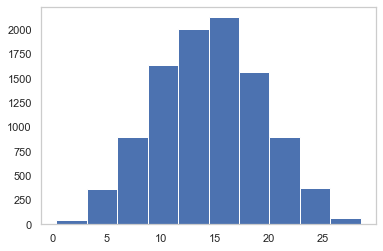

In [15]:
# distribution of target variable
h = plt.hist(y)

# Split the dataset
<hr style = "border:2px solid black" ></hr>

In [21]:
# train-validation split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=42)

In [22]:
# test set for generalization of scores
X_test, y_test = make_friedman1(n_samples=5000, n_features=7, noise=0.0, random_state=21)

# Plotting helper functions
<hr style = "border:2px solid black" ></hr>

In [23]:
def plot_residual_distribution(model):
    """
    Density plot of residuals (y_true - y_pred) for testation set for given model 
    """
    ax = sns.distplot(y_test - model.predict(X_test), hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, axlabel="Residual")
    title = ax.set_title('Kernel density of residuals', size=15)

In [24]:
def plot_scatter_pred_actual(model):
    """
    Scatter plot of predictions from given model vs true target variable from testation set
    """
    ax = sns.scatterplot(x=model.predict(X_test), y = y_test)
    ax.set_xlabel('Predictions')
    ax.set_ylabel('Actuals')
    title = ax.set_title('Actual vs Prediction scatter plot', size=15)    

# Assymetric Custom Loss
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-info">
<font color=black>

- In sklearn wrapper around LightGBM API: [1] objective: default parameter in model()and [2] eval_metric in model.fit() <br>
- Let's say that we don't want our model to overpredict, but we are fine with underpredictions. 
- We can make a custom loss which gives 10 times more penalty when the true targets.
- **NOTE THAT**: The behaviour of gradient of custom loss is as per our expecation. The slope has a little higher value when the residual is negative as compared to when it is positive

</font>
</div>

In [9]:
def custom_asymmetric_objective(y_true, y_pred):
    residual = (y_true - y_pred).astype("float")
    grad = np.where(residual < 0, -2*10.0*residual, -2*residual)
    hess = np.where(residual < 0, 2*10.0, 2.0)
    return grad, hess


def custom_asymmetric_eval(y_true, y_pred):
    residual = (y_true - y_pred).astype("float")
    loss = np.where(residual < 0, (residual**2)*10.0, residual**2)
    return "custom_asymmetric_eval", np.mean(loss), False

In [ ]:
# let's see how our custom loss function looks with respect to different prediction values

y_true = np.repeat(0, 1000)
y_pred = np.linspace(-100, 100, 1000)
residual = (y_true - y_pred).astype("float")

custom_loss = np.where(residual < 0, (residual**2)*10.0, residual**2)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.lineplot(y_pred, custom_loss, alpha=1, label="asymmetric mse")
sns.lineplot(y_pred, residual**2, alpha=0.5,
             label="symmetric mse", color="red")
ax.set_xlabel("Predictions")
ax.set_ylabel("Loss value")
fig.tight_layout()

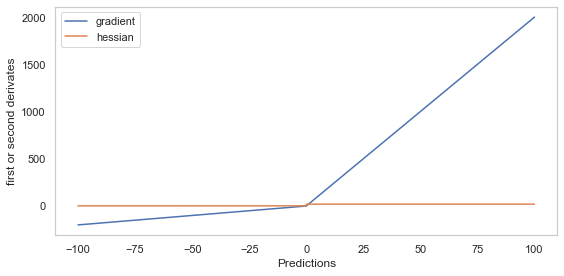

In [46]:
grad, hess = custom_asymmetric_objective(y_true, y_pred)

fig, ax = plt.subplots(1,1, figsize=(8,4))

# ax.plot(y_hat, errors)
ax.plot(y_pred, grad)
ax.plot(y_pred, hess)
ax.legend(('gradient', 'hessian'))
ax.set_xlabel('Predictions')
ax.set_ylabel('first or second derivates')

fig.tight_layout()

# Modelling
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-info">
<font color=black>

- We are going to try 6 models:
    - Random forest
    - LightGBM in its default settings
    - LightGBM + custom training loss
    - LightGBM + early stopping 
    - LightGBM + early stopping + custom loss
    - LightGBM + early stopping + custom loss + custom evaluation loss

</font>
</div>

### Random Forest

In [40]:
# basic random forest regressor with mse as criterion to measure the quality of split
#rf = RandomForestRegressor(n_estimators=50, oob_score=True, random_state=33)
rf = RandomForestRegressor(random_state=33)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=33)

In [ ]:
# distribution of residual
plot_residual_distribution(rf)

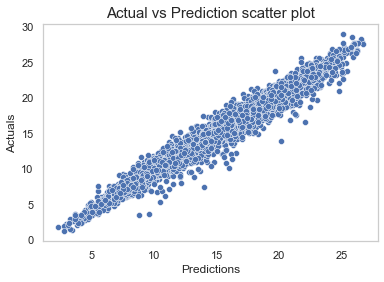

In [42]:
plot_scatter_pred_actual(rf)

In [43]:
print(f"MSE is {mean_squared_error(y_test, rf.predict(X_test))}")

MSE is 1.064593851801584


### Default LightGBM

#### LightGBM default: MSE


In [38]:
# make new model on new value
gbm = lightgbm.LGBMRegressor(random_state=33)
gbm.fit(X_train,y_train)

print(f"MSE is {mean_squared_error(y_test, gbm.predict(X_test))}")

MSE is 0.2362458093307746


We see that GBM has performed a better than random forest model for our validation MSE score

#### LightGBM default: MSE + early stopping


In [ ]:
# make new model on new value
gbm2 = lightgbm.LGBMRegressor(objective='regression',
                              random_state=33,
                              early_stopping_rounds=10,
                              n_estimators=10000
                              )
gbm2.fit(
    X_train,
    y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric='l2',  # also the default
    verbose=False,
)

print(f"MSE is {mean_squared_error(y_test, gbm2.predict(X_test))}")

#### LightGBM custom objective 

In [47]:
# make new model on new value
gbm3 = lightgbm.LGBMRegressor(random_state=33)
gbm3.set_params(**{'objective': custom_asymmetric_objective},
                metrics=["mse", 'mae'])

gbm3.fit(
    X_train,
    y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric='l2',
    verbose=False,
)

LGBMRegressor(metrics=['mse', 'mae'],
              objective=<function custom_asymmetric_objective at 0x13d0a9d30>,
              random_state=33)

#### LightGBM_early_boosting custom eval_metric


In [ ]:
# make new model on new value
gbm4 = lightgbm.LGBMRegressor(random_state=33,
                              early_stopping_rounds=10,
                              n_estimators=10000
                              )

gbm4.set_params(**{'objective': "regression"}, metrics=["mse", 'mae'])

gbm4.fit(
    X_train,
    y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric=custom_asymmetric_eval,
    verbose=False,
)

#### LightGBM_early_boosting custom objective

In [ ]:
# make new model on new value
gbm5 = lightgbm.LGBMRegressor(random_state=33,
                              early_stopping_rounds=10,
                              n_estimators=10000
                              )

gbm5.set_params(**{'objective': custom_asymmetric_objective},
                metrics=["mse", 'mae'])

gbm5.fit(
    X_train,
    y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric="l2",
    verbose=False,
)

#### LightGBM_early_boosting custom eval_metric + objective

In [ ]:
# make new model on new value
gbm6 = lightgbm.LGBMRegressor(random_state=33,
                              early_stopping_rounds=10,
                              n_estimators=10000
                              )

gbm6.set_params(**{'objective': custom_asymmetric_objective},
                metrics=["mse", 'mae'])

gbm6.fit(
    X_train,
    y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric=custom_asymmetric_eval,
    verbose=False,
)

# Post-processing
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-info">
<font color=black>

- **Random Forest vs. LightGBM**: Using default settings, LightGBM performs better than Random Forest on this dataset. 
- **LightGBM vs. LightGBM** with tuned early stopping rounds using MSE**: We see a big improvement in default MSE scores with just a small tweak of using early stopping rounds (MSE: 0.24 vs 0.14).    
- **LightGBM vs. LightGBM with tuned early stopping rounds using MSE**: Both the LightGBM models are optimizing MSE. We see a big improvement in default MSE scores with just a small tweak of using early stopping rounds (MSE: 0.24 vs 0.14). So, rather than limiting the number of boosting rounds to default (i.e., 100), we should let the model decide optimal number of boosting rounds using the early stopping hyper parameter. Hyper parameter optimization matters!
- **LightGBM with tuned early stopping rounds using MSE vs. LightGBM with tuned early stopping using custom MSE**: The scores from both of these models are very close with no material difference. This is because the the validation loss is only used to decide when to stop boosting. The gradient is optimizing default MSE in both the cases. Each subsequent tree produces same output for both of the models. The only difference is that the model with custom validation loss stops at 742 boosting iterations while the other runs for a few more
- **LightGBM with tuned early stopping using custom MSE vs. LightGBM trained on custom loss and tuned early stopping with MSE**: Only customizing the training loss without changing the validation loss hurts the model performance. The model with only custom training loss boosts for more rounds (1848) than other cases. If we observe carefully, this model has really low training loss (0.013) and is highly overfitting on the training set. Each gradient boosting iteration makes a new tree using training errors as target variables, but the boosting stops only when loss on validation data start increasing. The validation loss usually starts increasing when the model starts overfitting, which is the signal to stop building more trees. In this case, since validation and training loss are not aligned with each other, the model doesn’t seem to “get the message” which leads to overfitting. This configuration was just included for completeness and is not something one should use in practice.
- **LightGBM with tuned early stopping rounds with MSE vs. LightGBM trained on custom training loss and tuned early stopping rounds with customized validation loss**: The final model uses both custom training and validation losses. It gives the best asymmetric MSE score with relatively small number of boosting iterations. The losses are aligned with what we care about!
    
</font>
</div>

In [52]:
# asymmetric mse scores
_,loss_rf,_ = custom_asymmetric_eval(y_test, rf.predict(X_test))
_,loss_gbm,_ = custom_asymmetric_eval(y_test, gbm.predict(X_test))
_,loss_gbm2,_ = custom_asymmetric_eval(y_test, gbm2.predict(X_test))
_,loss_gbm3,_ = custom_asymmetric_eval(y_test, gbm3.predict(X_test))
_,loss_gbm4,_ = custom_asymmetric_eval(y_test, gbm4.predict(X_test))
_,loss_gbm5,_ = custom_asymmetric_eval(y_test, gbm5.predict(X_test))
_,loss_gbm6,_ = custom_asymmetric_eval(y_test, gbm6.predict(X_test))

In [53]:
score_dict = {'Random Forest default':
              {'asymmetric custom mse (test)': loss_rf,
               'asymmetric custom mse (train)': custom_asymmetric_eval(y_train, rf.predict(X_train))[1],
               'symmetric mse': mean_squared_error(y_test, rf.predict(X_test)),
               '# boosting rounds' : '-'},
              
              'LightGBM default' : 
              {'asymmetric custom mse (test)': loss_gbm,
              'asymmetric custom mse (train)': custom_asymmetric_eval(y_train, gbm.predict(X_train))[1],
               'symmetric mse': mean_squared_error(y_test, gbm.predict(X_test)), 
               '# boosting rounds' : gbm.booster_.current_iteration()},
              
              'LightGBM with custom training loss (no hyperparameter tuning)': 
              {'asymmetric custom mse (test)': loss_gbm3,
               'asymmetric custom mse (train)': custom_asymmetric_eval(y_train, gbm3.predict(X_train))[1],               
               'symmetric mse': mean_squared_error(y_test, gbm3.predict(X_test)),
               '# boosting rounds' : gbm3.booster_.current_iteration()},
              
              'LightGBM with early stopping' : 
              {'asymmetric custom mse (test)': loss_gbm2,
               'asymmetric custom mse (train)': custom_asymmetric_eval(y_train, gbm2.predict(X_train))[1],
               'symmetric mse': mean_squared_error(y_test, gbm2.predict(X_test)),
               '# boosting rounds' : gbm2.booster_.current_iteration()},

             'LightGBM with early_stopping and custom validation loss': 
              {'asymmetric custom mse (test)': loss_gbm4,
               'asymmetric custom mse (train)': custom_asymmetric_eval(y_train, gbm4.predict(X_train))[1],
               'symmetric mse': mean_squared_error(y_test, gbm4.predict(X_test)),
               '# boosting rounds' : gbm4.booster_.current_iteration()},
              
              'LightGBM with early_stopping and custom training loss': 
              {'asymmetric custom mse (test)': loss_gbm5,
               'asymmetric custom mse (train)': custom_asymmetric_eval(y_train, gbm5.predict(X_train))[1],
               'symmetric mse': mean_squared_error(y_test, gbm5.predict(X_test)),
               '# boosting rounds' : gbm5.booster_.current_iteration()}, 
              
              'LightGBM with early_stopping, custom training and custom validation loss': 
              {'asymmetric custom mse (test)': loss_gbm6,
               'asymmetric custom mse (train)': custom_asymmetric_eval(y_train, gbm6.predict(X_train))[1],
               'symmetric mse': mean_squared_error(y_test, gbm6.predict(X_test)),
               '# boosting rounds' : gbm6.booster_.current_iteration()}
             
             }

In [54]:
pd.DataFrame(score_dict).T

,asymmetric custom mse (test),asymmetric custom mse (train),symmetric mse,# boosting rounds
Random Forest default,5.96749,0.897008,1.064594,-
LightGBM default,1.318521,0.628296,0.236246,100.0
LightGBM with custom training loss (no hyperparameter tuning),0.839062,0.280541,0.345089,100.0
LightGBM with early stopping,0.783725,0.053172,0.137639,780.0
LightGBM with early_stopping and custom validation loss,0.78697,0.059067,0.138275,742.0
LightGBM with early_stopping and custom training loss,0.813875,0.032643,0.181109,898.0
"LightGBM with early_stopping, custom training and custom validation loss",0.776099,0.182956,0.277859,172.0


<div class="alert alert-info">
<font color=black>

- Note that with LightGBM (even with default hyperparameters), the prediction performance improves as compared to the Random Forest model. 
- The final model with custom validation loss appears to make more predictions on the right side of histogram, i.e. the actual values are greater than the predicted values. 
- This is expected because of the asymmetric custom loss function. 
- This right sided shift of the residuals can be better visualized using a kernel density plot of the residuals.

</font>
</div>

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
ax = sns.distplot(y_test - gbm.predict(X_test), hist=False, kde=True,
                  kde_kws={'shade': True, 'linewidth': 3}, axlabel="Residual", label="LightGBM with default mse")
ax = sns.distplot(y_test - gbm3.predict(X_test), hist=False, kde=True,
                  kde_kws={'shade': True, 'linewidth': 3}, axlabel="Residual", label="LightGBM with asymmetric mse")

# control x and y limits
ax.set_xlim(-3, 3)

title = ax.set_title('Kernel density plot of residuals', size=15)

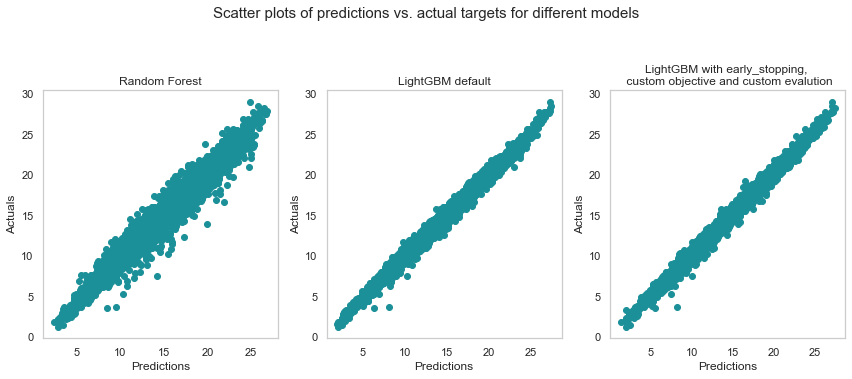

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 5))
ax1, ax2, ax3 = ax.flatten()

ax1.plot(rf.predict(X_test), y_test, 'o', color='#1c9099')
ax1.set_xlabel('Predictions')
ax1.set_ylabel('Actuals')
ax1.set_title('Random Forest')

ax2.plot(gbm.predict(X_test), y_test, 'o', color='#1c9099')
ax2.set_xlabel('Predictions')
ax2.set_ylabel('Actuals')
ax2.set_title('LightGBM default')

ax3.plot(gbm6.predict(X_test), y_test, 'o', color='#1c9099')
ax3.set_xlabel('Predictions')
ax3.set_ylabel('Actuals')
ax3.set_title(
    'LightGBM with early_stopping, \n custom objective and custom evalution')

fig.suptitle(
    "Scatter plots of predictions vs. actual targets for different models", y=1.05, fontsize=15)
fig.tight_layout()

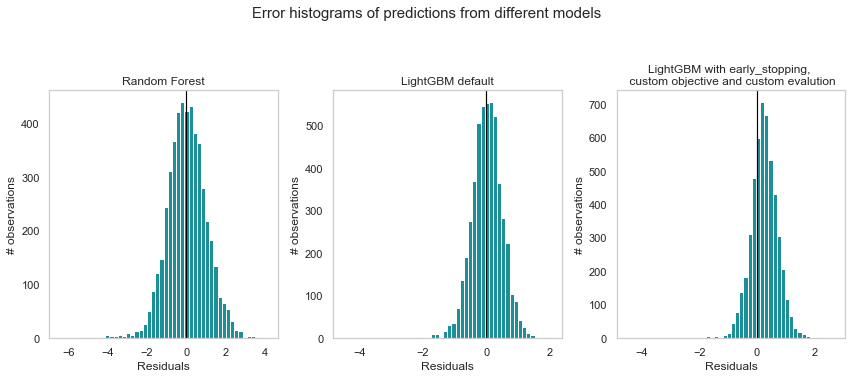

In [56]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 5))
ax1, ax2, ax3 = ax.flatten()

ax1.hist(y_test - rf.predict(X_test), bins=50, color='#1c9099')
ax1.axvline(x=0, ymin=0, ymax=500, color='black', lw=1.2)
ax1.set_xlabel('Residuals')
ax1.set_title('Random Forest')
ax1.set_ylabel('# observations')

ax2.hist(y_test - gbm.predict(X_test), bins=50,  color='#1c9099')
ax2.axvline(x=0, ymin=0, ymax=500, color='black', lw=1.2)
ax2.set_xlabel('Residuals')
ax2.set_ylabel('# observations')
ax2.set_title('LightGBM default')

ax3.hist(y_test - gbm6.predict(X_test), bins=50,  color='#1c9099')
ax3.axvline(x=0, ymin=0, ymax=500, color='black', lw=1.2)
ax3.set_xlabel('Residuals')
ax3.set_ylabel('# observations')
ax3.set_title(
    'LightGBM with early_stopping, \n custom objective and custom evalution')

fig.suptitle(
    "Error histograms of predictions from different models", y=1.05, fontsize=15)
fig.tight_layout()

# Conclusions
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-danger">
<font color=black>

- In certain scenarios, we intentionally want our model to **bias** our errors in a certain direction, depending on which errors are more costly. 

</font>
</div>

# References
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-warning">
<font color=black>

- [Article](https://towardsdatascience.com/custom-loss-functions-for-gradient-boosting-f79c1b40466d)
- [Code](https://github.com/manifoldai/mf-eng-public/blob/master/notebooks/custom_loss_lightgbm.ipynb)

</font>
</div>